In [3]:
from tqdm import tqdm 
import copy
import numpy as np
from scipy.special import digamma, loggamma

In [4]:
K = 20 # Number of topics
V = 50 # Number of terms in the vocabulary
N = 10 # Number of documents
M = 20 # Number of words per document
ETA = 0.5 # Hyperparameter for V-Dirichlet topics prior
ALPHA = 0.5 # Hyperparameter for K-Dirichlet topics proportion prior

def sim_LDA(K, V, N, M):
    # For each topic in k = 1,...,K, draw topic distributions
    BETA = np.random.dirichlet(ETA * np.ones(V), K)

    X = [] # Initialize empty list for complete collection of documents
    for i in range(N): # Iterate over number of documents i = 1,...,N
        THETA = np.random.dirichlet(ALPHA * np.ones(K), N) # Draw topic proportions
        x = []
        for _ in range(M): # Iterate over each word
            z_ij = np.random.choice(K, p=THETA[i]) # Draw topic assignment
            x_ij = np.random.choice(V, p=BETA[z_ij]) # Draw observed word
            x.append(x_ij)
        X.append(x)

    X = np.asarray(X) # Convert collection of documents to numpy array
    return X
X = sim_LDA(K, V, N, M)

In [5]:
def init_variation_params(X, K, V):
    N, M = X.shape
    LAMBDA = np.random.uniform(low=0.01, high=1.00, size=(K, V))
    GAMMA = np.ones(shape=(N, K))
    PHI = np.ones(shape=(N, M, K)) * 1/K

    return LAMBDA, GAMMA, PHI

In [26]:
def compute_ELBO(LAMBDA, GAMMA, PHI, X):
    N, M = X.shape
    ELBO = 0

    E_log_p_BETA = 0
    for k in range(K):
        E_log_p_BETA += (ETA - 1) * np.sum(digamma(LAMBDA[k]) - digamma(np.sum(LAMBDA[k])))
    ELBO += E_log_p_BETA

    E_log_p_THETA = 0
    for i in range(N):
        E_log_p_THETA += (ALPHA - 1) * np.sum(digamma(GAMMA[i]) - digamma(np.sum(GAMMA[i])))
    ELBO += E_log_p_THETA

    E_q_log_p_z_x = 0
    for i in range(N):
        for j in range(M):
            x_ij = X[i,j]
            E_q_log_p_z_x += np.sum(PHI[i,j] * (digamma(GAMMA[i]) - digamma(np.sum(GAMMA[i])))) \
                + np.sum(PHI[i,j] * (digamma(LAMBDA[:, x_ij])) - digamma(np.sum(LAMBDA[:, x_ij], axis=0)))
    ELBO = E_q_log_p_z_x

    E_log_q_BETA = 0
    for k in range(K):
        E_log_q_BETA += -loggamma(np.sum(LAMBDA[k])) + np.sum(loggamma(LAMBDA[k])) \
            - np.sum((LAMBDA[k] - 1) * (digamma(LAMBDA[k]) - digamma(np.sum(LAMBDA[k]))))
    ELBO += E_log_q_BETA

    E_log_q_THETA = 0
    for i in range(N):
        E_log_q_THETA += -loggamma(np.sum(GAMMA[i])) + np.sum(loggamma(GAMMA[i])) \
            - np.sum((GAMMA[i] - 1) * (digamma(GAMMA[i]) - digamma(np.sum(GAMMA[i]))))
    ELBO += E_log_q_THETA

    E_q_log_z = 0
    for i in range(N):
        for j in range(M):
            E_q_log_z += -np.sum(PHI[i,j] * np.log(PHI[i,j]))
    ELBO += E_q_log_z

    return ELBO

In [32]:
def log_sum_exp(vec):
    alpha = np.max(vec, axis=0)
    log_sum_exp = np.log(np.sum(np.exp(vec - alpha))) + alpha

    return log_sum_exp

np.min(X), np.max(X), V

(np.int64(2), np.int64(97), 100)

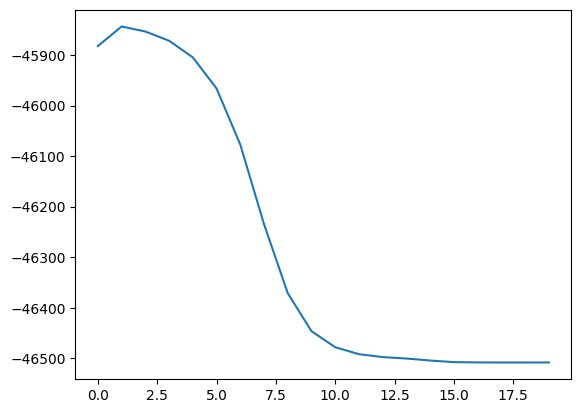

In [28]:
ETA = 0.5
ALPHA = 0.25
K = 60
V = 100
N = 10
M = 10
X = sim_LDA(K, V, N, M)
LAMBDA_init, GAMMA_init, PHI_init = init_variation_params(X, K, V)
LAMBDA = LAMBDA_init
GAMMA = GAMMA_init
PHI = PHI_init
ELBOs = [0, 100] # Initialize ELBOs so that first differences are greater than 10e-4
counter = 1

# Continue to update variational parameters until ELBO has converged
while np.abs(ELBOs[counter] - ELBOs[counter-1]) > 10e-4:
    # Iteratate over the j-th word in the i-th document
    for i in range(N):
        for j in range(M):
            x_ij = X[i,j]
            exp_prop = digamma(LAMBDA[:, x_ij]) - digamma(np.sum(LAMBDA[:, x_ij])) \
                + digamma(GAMMA[i]) - digamma(np.sum(GAMMA[i]))

            # Update (i,j)-th element of PHI (use log-sum-exp trick to normalize topic assignment)
            PHI[i, j] = np.exp(exp_prop - log_sum_exp(exp_prop))

        # Updata i-th component of GAMMA by ALPHA_k + E[m_ik(z_i)]; expectation is sum of PHI_ijk over j=1,...,M
        GAMMA[i] =  ALPHA * np.ones(K) + np.sum(PHI[i, :], axis=0)

    # Update (k,v)-th coordinate of variational topic LAMBDA
    for k in range(K):
        for v in range(V): 
            # Update is ETA plus the sum of x_ij^(v) PHI_ijk over i=1,...,N and j=1,...,M, where x_ij^(v) = 1{x_ij = v}
            LAMBDA[k, v] = ETA + np.sum([[float(X[i,j] == v) * PHI[i, j][k] for i in range(N)] for j in range(M)])
    
    ELBOs.append(compute_ELBO(LAMBDA, GAMMA, PHI, X))
    counter += 1
ELBOs = ELBOs[2:]

import matplotlib.pyplot as plt

plt.plot(range(len(ELBOs)), ELBOs)